$\newcommand{\ENC}{{\small\mathrm{ENC}}}$
$\newcommand{\DEC}{{\small\mathrm{DEC}}}$
$\newcommand{\similarity}{\mathrm{similarity}}$


**After this laboratory you should be able to**
- Explain what an **embedding** is and the motivation for it
- Explain the **encoder-decoder paradigm**
- Understand SVD and **Random walk embeddings**
- Explore Spectral embeddings
- Explore Graph embeddings
- Read the papers provided

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

# Might be worth to take a look at this https://github.com/sknetwork-team/scikit-network

## Library 
We are going to use https://karateclub.readthedocs.io/en/latest/ library for most of the algorithms

## Utils

In [36]:
parent_dir = os.path.abspath(os.path.join(".."))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)

from utils.utils import (
    giant_component,
    load_graph,
)

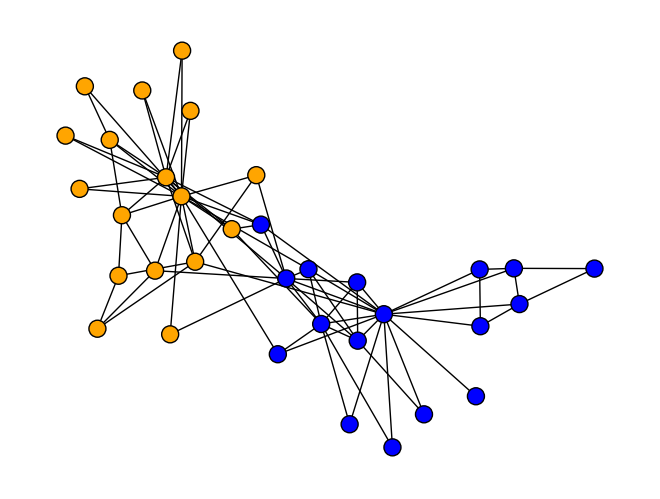

In [37]:
# Load karate

G_karate = nx.karate_club_graph()
karate_color = [
    "blue" if club == "Mr. Hi" else "orange" for club in list(nx.get_node_attributes(G_karate, "club").values())
]
nx.draw_spring(G_karate, node_color=karate_color, node_size=150, edgecolors="black")

In [38]:
G_football = load_graph("football")

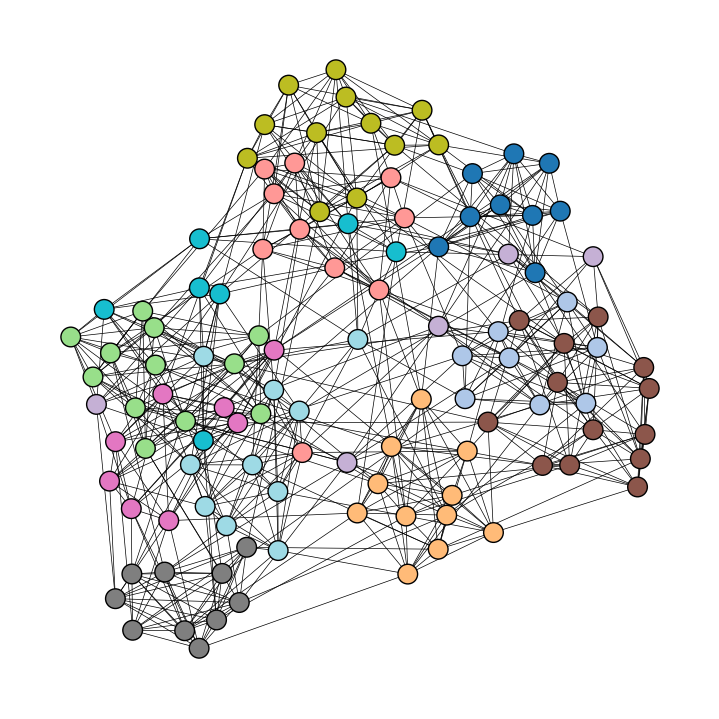

In [39]:
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G_football, k=2, iterations=1000)
football_color = list(nx.get_node_attributes(G_football, "value").values())
football_labels = np.array(football_color)
nx.draw(
    G_football,
    pos=pos,
    node_size=200,
    width=0.5,
    edgecolors="black",
    node_color=football_color,
    cmap=plt.cm.tab20,
)

,nodes,label
0,1,3
1,2,6
2,3,5
3,4,5
4,5,4


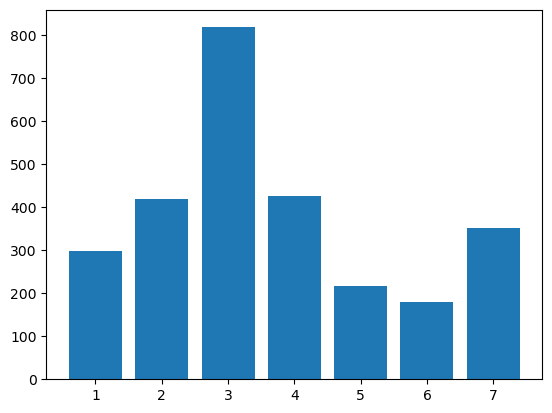

Graph with 2485 nodes and 5069 edges


In [40]:
# Load cora
G_cora = nx.read_weighted_edgelist(os.path.join("..", "data", "cora.edges"), delimiter=",")


df = pd.read_csv(
    os.path.join("..", "data", "cora.node_labels"),
    delimiter=",",
    names=["nodes", "label"],
)
display(df.head())
plt.bar(*np.unique(df["label"], return_counts=True))
plt.show()

d = {str(k): {"label": v} for k, v in zip(df["nodes"], df["label"])}
nx.set_node_attributes(G_cora, d)

G_cora = giant_component(G_cora)
print(G_cora)

G_cora = nx.relabel_nodes(G_cora, {k: v for k, v in zip(G_cora.nodes, range(len(G_cora.nodes)))})
cora_color = list(nx.get_node_attributes(G_cora, "label").values())

In [41]:
num_communities = 3
num_nodes_per_community = 32
G_comm = nx.planted_partition_graph(l=num_communities, k=num_nodes_per_community, p_in=0.5, p_out=0.1, seed=42)
colors = ["violet", "lightgreen", "lightblue", "yellow"]
comm_color = [colors[v] for v in nx.get_node_attributes(G_comm, "block").values()]
comm_labels = np.array(list(nx.get_node_attributes(G_comm, "block").values()))

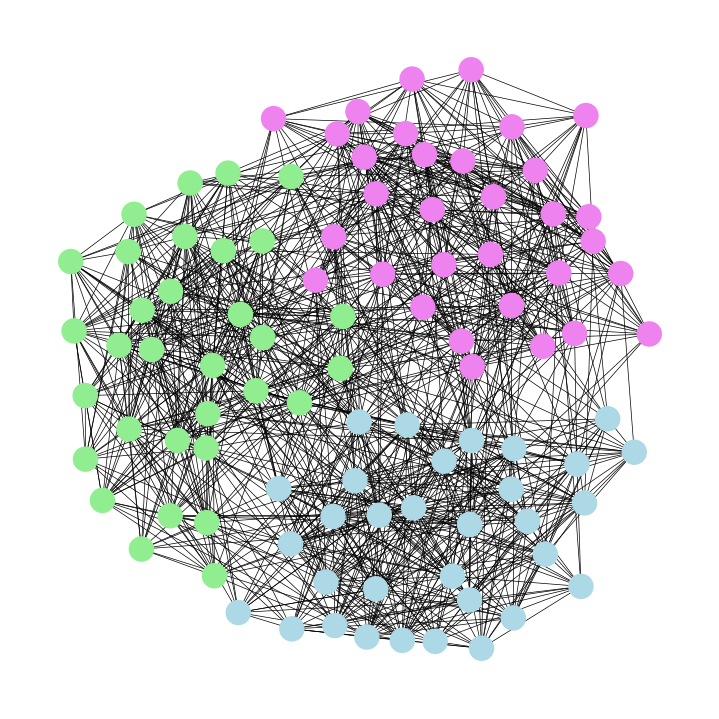

In [42]:
plt.figure(figsize=(7, 7))
nx.draw_kamada_kawai(G_comm, node_color=comm_color, width=0.5)

# Embeddings

**Motivations/ task**
1. Basic  ML models work simple data types:
    Images are 2d grids, text to speech is 1d, tabular data is ... tabular.  
    Graphs have variable nodes, variable edges, no reference point (what is top left, what is top right in a graph?)  
    What about an adjacency matrix? If you want to feed an adjacency matrix into a network there will be issues. Can you think of a few?.  
    **Task**: We want to compress graph features into an $\mathbb R^d$ dimensional space.
2. We can train **graph encoders** to extract features better than we can. 

Image from cs224w  
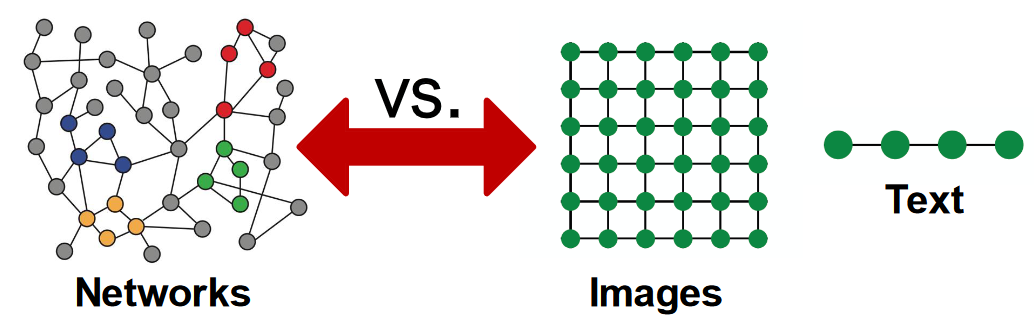

*Intuition*:
- Similarity of embeddings between nodes = similarity in their networks. Ex: both nodes are "close" in the network in some sense (connected with an edge)

**Types of embeddings**
- Node embeddings
- Link embeddings
- Graph embeddings



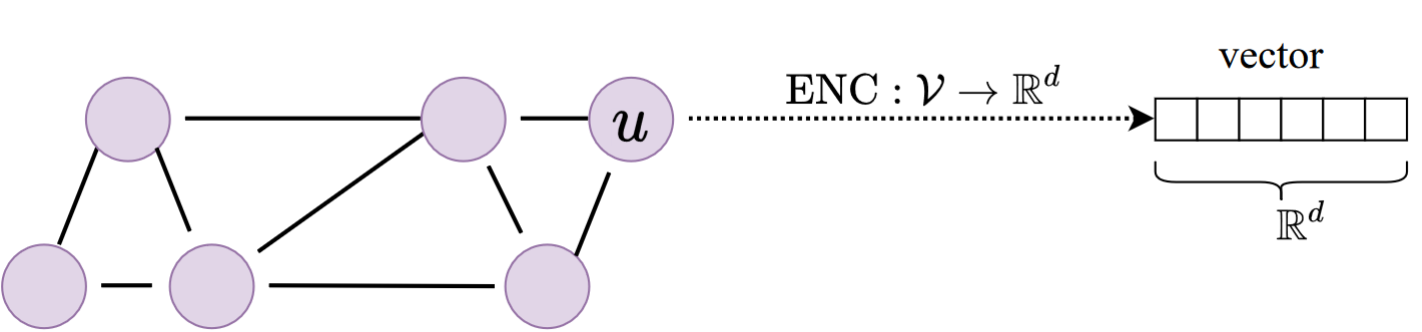

# Encoder-decoder paradigm

Let $G$ be a graph with nodes in $V$ and edges in $E$ and with the adj matrix $A$.  
Let $u \in V$ be a node in $G$ and $h_u \in \mathbb R^d$ its $d$ dimensional embedding.

**Goal**: Learn encoder-decoders such that when encoded the nodes are closed together

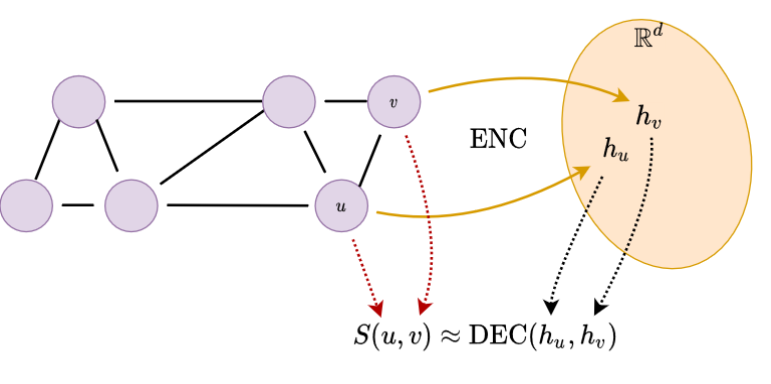

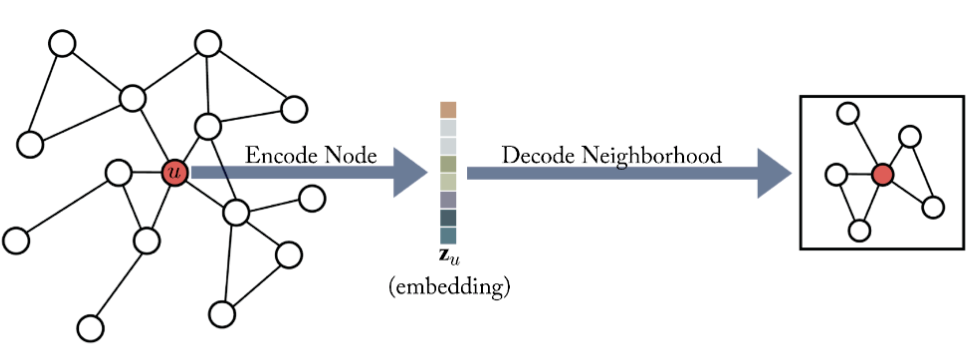

## Encoder
$$\ENC: V \to \mathbb R^d$$

Example  
**Shallow embeddings -- Embedding lookup**
$$\ENC(u) = H[u]$$ 
where $H \in \mathbb R^{|V| \times d}$ is a matrix containing the embedding vectors for all nodes and $H[u]$ denotes
the row of $H$ corresponding to node $v$.

The goal would be to learn the matrix $H$ -- Intensive to compute, easy to lookup

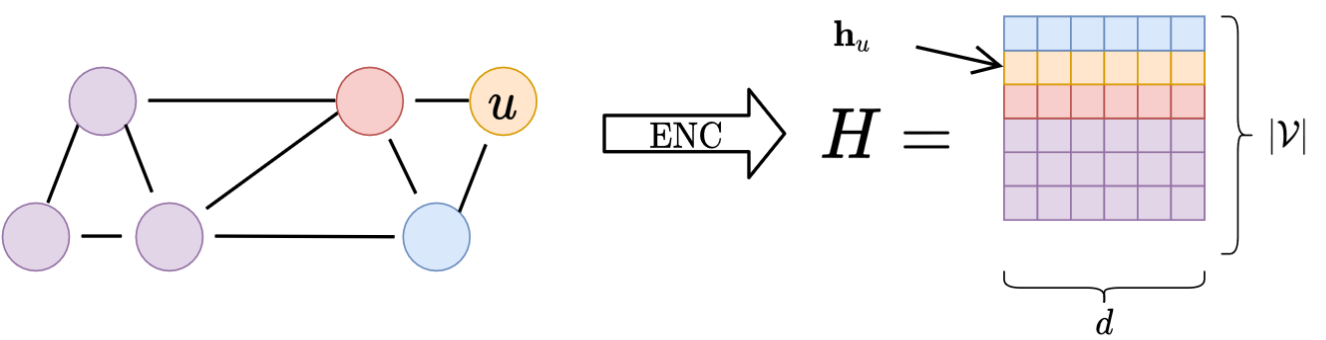

**Remark**
- This is a **shallow encoder** (it's just a lookup). There are encoders that use both *node features* and the *local graph structure* to generate embeddings. These generalized encoder architectures are called **Graph Neural Networks**

## Decoder
Will be based on the node similarity function. The standard practice is to define *pairwise decoders* that predict similarity between nodes

$$\DEC : \mathbb R^d \times \mathbb R^d \to \mathbb R$$

with the desired property:
$$ \DEC(\ENC(u), \ENC(v)) = \DEC(h_u, h_v) \approx \similarity(u, v)$$

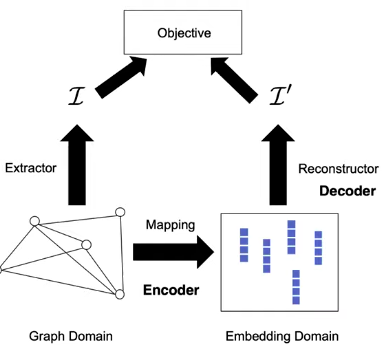

## Node similarity function
**Similarity function**  
Specifies how the relationships in the vector space map to the relationships in the original network

$$\similarity(u, v) \approx h_v^T h_u$$
Intuition for dot product: if 2 node embeddings are "perpendicular" (not close) their dot product is $0$. If they are close they have a high dot product

**How to define the similarity?**  
There are many ways to define similarities. Are the nodes linked? Do they share neighbours?. 

0
9


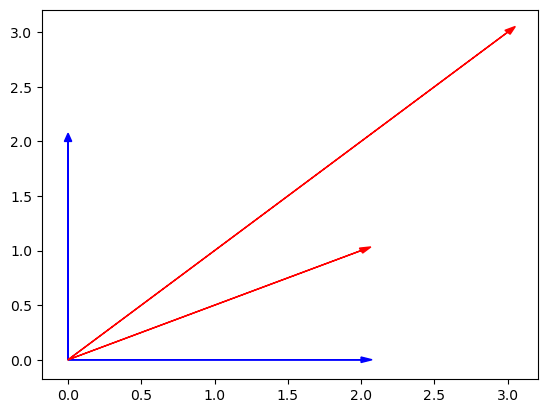

In [43]:
x0 = np.array([0, 2])
x1 = np.array([2, 0])
print(x0.dot(x1))

y0 = np.array([2, 1])
y1 = np.array([3, 3])
print(y0.dot(y1))

plt.arrow(0, 0, x0[0], x0[1], head_width=0.05, color="blue")
plt.arrow(0, 0, x1[0], x1[1], head_width=0.05, color="blue")
plt.arrow(0, 0, y0[0], y0[1], head_width=0.05, color="red")
plt.arrow(0, 0, y1[0], y1[1], head_width=0.05, color="red")
# plt.plot(hv)

## Limitations of shallow embeddings

1. A shallow embedding does not share parameters between nodes in the encoder (the encoder directly optimizes a **unique embedding** vector for each node) => Statistically and computationally inneficient. The number of parameters in a shallow embedding grows with the number of nodes
2. Does not leverage node features in the encoder.
3. *Transitive methods* -- Can only generate embeddings for nodes that were present during the training phase. New embeddings are not possible unless additional optimizations are performed to learn the embeddings => We can't generalize.
4. Cannot capture structural similarity (Except anonymous walks, will be discussed later)

# Torch `Embedding` layer

The `torch.nn.Embedding` is a layer that acts like a lookup table.  
Important arguments:
- `num_embeddings` -- number of embeddings
- `embedding_dim` -- the dimension of embeddings

In [44]:
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

In [45]:
# Let's look at a simple layer that has 4 embeddings of dimension 8
# This embedding layer can contain 4 nodes, each with an 8-dim embedding
emb_layer = torch.nn.Embedding(num_embeddings=4, embedding_dim=8)
print(emb_layer)

Embedding(4, 8)


In [46]:
# To inspect the data we can use `.weight.data`
emb_layer.weight.data

tensor([[-0.5551, -1.0901, -0.4139,  0.4476, -1.6411, -1.7220,  1.4086,  0.9558],
        [-0.3724,  1.5830, -0.7537,  0.2286, -0.5763, -0.7944,  0.8025,  1.6749],
        [-0.3025,  0.2594, -0.5506, -1.3845,  0.0992, -0.7009, -0.8698,  1.2390],
        [-1.4799, -0.9200,  0.2403, -0.0158,  1.4791, -0.4473,  2.1209, -0.3387]])

In [47]:
# To get the embeddings by indexes we can call the embedding with a `torch.Tensor` of dtype `long`
idxs = torch.tensor([0, 2], dtype=torch.long)
print(type(idxs))
emb_layer(idxs)

<class 'torch.Tensor'>


tensor([[-0.5551, -1.0901, -0.4139,  0.4476, -1.6411, -1.7220,  1.4086,  0.9558],
        [-0.3025,  0.2594, -0.5506, -1.3845,  0.0992, -0.7009, -0.8698,  1.2390]],
       grad_fn=<EmbeddingBackward0>)

## Training an embedding

Now let's train an embedding on a graph

We need to establish what we want to predict. We said that nodes that should be close should have a higher dot product. Therefore we want nodes that have an **edge between** them to have a higher dot product. So we want to predict if there is an edge between 2 nodes or not. (Another task would be to predict nodes that are in the same community to have a higher dot product)

To do that we need to sample positive edges (edges that exist) and negative edges (edges that don't exist). We will sample the same number of positive and negative edges to have a balanced dataset.

After that we will take the dot products between all node embeddings pairs and transform them into a probabilities (using `torch.sigmoid`). We will use Binary cross entropy to calculate our loss and finally we will update our embedding.

In [48]:
# Get all edges in the graph. We call them `positive`
positive_edge_index = torch.tensor(np.array(list(G_comm.edges)), dtype=torch.long).T
positive_edge_index
print(positive_edge_index.shape[1])

1016


In [49]:
# Get all negative edges.
all_negative_edges = np.array(list(nx.non_edges(G_comm)))
num_neg_edges = len(all_negative_edges)
num_neg_edges

3544

In [50]:
# Sample the same number of negative edges as positive edges to have a balanced dataset
idxs = np.random.choice(num_neg_edges, size=positive_edge_index.shape[1], replace=False)
negative_edge_index = torch.tensor(all_negative_edges[idxs]).T
negative_edge_index

tensor([[49, 34,  7,  ..., 62, 14, 29],
        [86, 90, 80,  ..., 72, 71, 69]])

In [51]:
# Initialize the embedding, optimizer and loss function. You can play with embedding_dim here
emb_layer = torch.nn.Embedding(num_embeddings=G_comm.number_of_nodes(), embedding_dim=2)
# optimizer = torch.optim.SGD(emb_layer.parameters(), lr=0.1)
optimizer = torch.optim.Adam(emb_layer.parameters(), lr=0.001)
loss_function = torch.nn.BCELoss()

In [52]:
# Prepare the dataset
positive_labels = torch.ones(positive_edge_index.shape[1])
negative_labels = torch.zeros(positive_edge_index.shape[1])
y = torch.cat([positive_labels, negative_labels], dim=0)
edges = torch.cat([positive_edge_index, negative_edge_index], dim=1)

# Transfer to gpu if you have
emb_layer = emb_layer.to(device)

In [53]:
def train(emb, edges, y, loss_fn, optimizer):

    edges = edges.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    # Take the embeddings of nodes
    emb_u = emb(edges[0])
    emb_v = emb(edges[1])

    # Calculate dot products between each node pair
    dot_prod = torch.sum(emb_u * emb_v, dim=1)
    # Transform into predictions
    out = torch.sigmoid(dot_prod)
    # Calculate the loss
    loss = loss_fn(out, y)
    # Derive gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    acc = torch.mean((torch.round(out) == y).float())
    return loss.item(), acc.item()

In [54]:
epochs = 5001
for epoch in range(1, epochs):
    loss_train, acc_train = train(emb_layer, edges, y, loss_function, optimizer)

    if epoch % 1000 == 0:
        print(f"{epoch=} \t {loss_train=:.4f} | {acc_train=:.4f}")

epoch=1000 	 loss_train=0.6413 | acc_train=0.6260
epoch=2000 	 loss_train=0.5518 | acc_train=0.7067
epoch=3000 	 loss_train=0.5180 | acc_train=0.7456
epoch=4000 	 loss_train=0.5111 | acc_train=0.7416
epoch=5000 	 loss_train=0.5095 | acc_train=0.7475


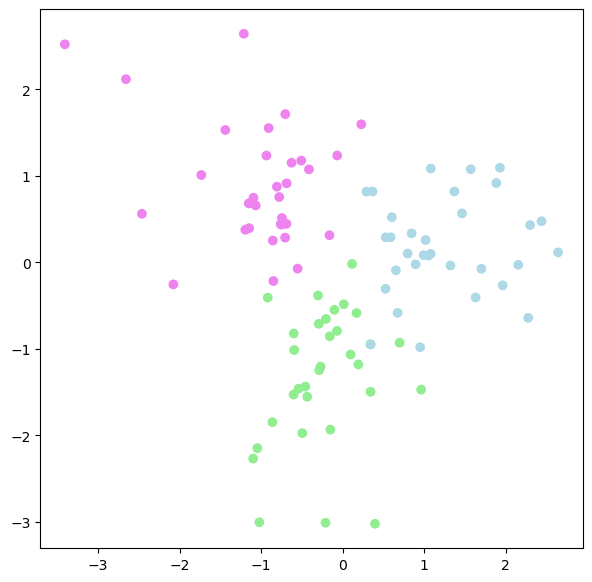

In [55]:
emb = emb_layer.weight.data.cpu().numpy()

plt.figure(figsize=(7, 7))
plt.scatter(
    *emb.T,
    # *PCA(n_components=2).fit_transform(emb).T,
    c=comm_color,
    # cmap=plt.cm.tab20
)
plt.show()

In [56]:
# Let's take some embeddings from the same communities and compare their dot product
# z1 and z2 are from the same community therefore they should have a bigger dot product than z1 and z3
z1 = emb[np.random.choice(np.where(comm_labels == 0)[0])]
z2 = emb[np.random.choice(np.where(comm_labels == 0)[0])]
z3 = emb[np.random.choice(np.where(comm_labels == 1)[0])]

print(z1.dot(z2))
print(z1.dot(z3))

0.70459414
-0.35115504


# Random walks embeddings

Relevant papers

[deepwalk paper](https://arxiv.org/pdf/1403.6652.pdf) -- read it  
[node2vec paper](https://arxiv.org/pdf/1607.00653.pdf)  
[Random walks as matrix factorization](https://arxiv.org/pdf/1710.02971.pdf)

Goal: Find $h_u$ -- the embedding of $u$

*Intuition*:  
Estimate probability of visiting a node $v$ on a random walk starting from node $u$ using a random strategy $R$ -- we want to estimate $P_R(v | u)$.  
If the nodes are *closer* they will get visited multiple times. Therefore if we have a high $P_R(v | u)$ we want a big $h_v^Th_u$

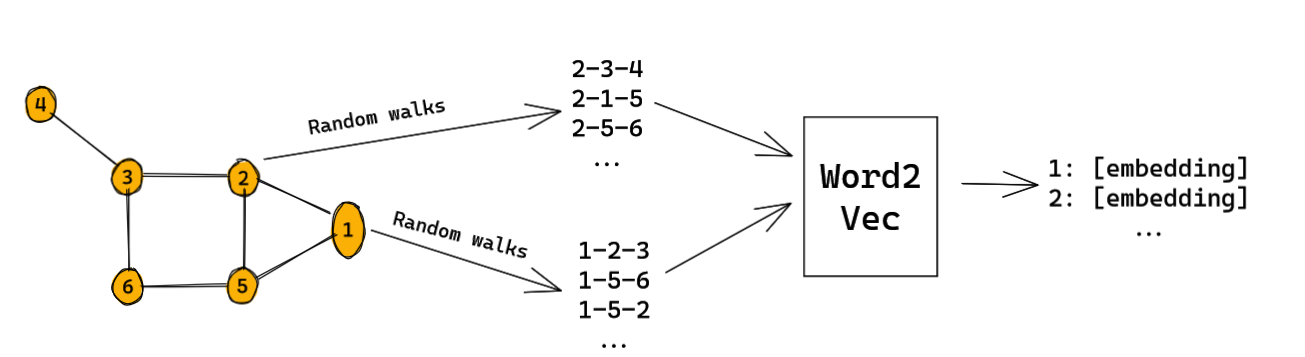

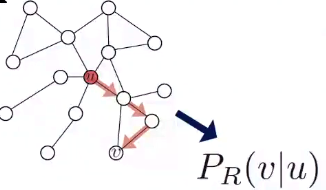



Algorithm
1. Run random walks
2. For each node $u$ look at the neighbourhood generated by ranom walks starting from $u$-- $N_R(u)$
3. Form an optimization problem that you can iteratively solve using SGD (Stochastic Gradient Descent). Minimze the following:
$$\mathcal L = \sum_{u \in V}\sum_{v\in N_r(u)} -\log(P(v|h_u))$$

**Random walk**  
Given a graph and a starting point we select a neighbour of it at random and move to the neighbour. We repeat a given number of steps.

**Walking strategy $R$**
- You can go randomly
- **node2vec**: You can go DFS or BFS to get a micro neighbourhood view or a macro neighbourhood view. Parametrize it with 2 parameters $p$ -- probability to return to previous node -- and $q$ -- ratio between DFS and BFS

In [57]:
from typing import Any, List

# from gensim.models.word2vec import Word2Vec
from utils.word2vec import Word2Vec

In [58]:
def walk_node(graph: nx.Graph, node: Any, walk_length: int) -> List[Any]:
    """Given a graph, a node and a walk_length, walks the graph starting from that node"""
    # Add the initial node to the walk
    walk = [node]

    for _ in range(walk_length - 1):
        # Pick neighbours from the last node in the walk
        neighbours = list(graph.neighbors(walk[-1]))
        # If the node has neighbours, sample and add to the walk
        if len(neighbours) > 0:
            next_node = np.random.choice(neighbours)
            walk.append(next_node)
    return walk


def walk_graph(graph: nx.Graph, walks_per_node: int, walk_length: int) -> List[List[Any]]:
    """Given a graph, how many walks_per_node and the walk_length, for each node do
    walks_per_node walks of length walk_length starting from it. Add the walk to a list
    and return it"""
    walks = []
    # For each node, do `walks_per_node` random walks
    for node in graph.nodes():
        for _ in range(walks_per_node):
            walk = walk_node(graph, node, walk_length)
            walks.append(walk)
    return walks

In [98]:
start_node = 0
walk_length = 10
walks_per_node = 10
print(start_node)
walk = walk_node(G_comm, start_node, walk_length)
print(walk)

0
[0, np.int64(24), np.int64(11), np.int64(19), np.int64(39), np.int64(63), np.int64(35), np.int64(40), np.int64(34), np.int64(56)]


In [99]:
walks = walk_graph(G_comm, walks_per_node=walks_per_node, walk_length=walk_length)
print(G_comm.number_of_nodes(), len(walks))

96 960


In [100]:
# Transform entries into strings, since they must be "words" for word2vec to work.
for i in range(len(walks)):
    for j in range(walk_length):
        walks[i][j] = str(walks[i][j])

In [101]:
walks

[['0', '24', '10', '15', '52', '61', '6', '23', '4', '13'],
 ['0', '10', '2', '8', '13', '9', '24', '60', '55', '62'],
 ['0', '28', '77', '95', '66', '49', '51', '38', '56', '11'],
 ['0', '9', '30', '29', '18', '27', '16', '49', '16', '52'],
 ['0', '4', '11', '0', '3', '7', '20', '7', '25', '53'],
 ['0', '24', '22', '38', '84', '81', '26', '37', '47', '60'],
 ['0', '27', '5', '17', '9', '24', '0', '11', '23', '12'],
 ['0', '23', '56', '84', '38', '48', '61', '53', '25', '78'],
 ['0', '10', '30', '83', '68', '77', '81', '88', '83', '67'],
 ['0', '17', '26', '16', '9', '19', '24', '10', '92', '78'],
 ['1', '50', '94', '54', '24', '85', '42', '43', '58', '88'],
 ['1', '15', '81', '72', '92', '3', '14', '19', '5', '92'],
 ['1', '5', '89', '81', '34', '52', '45', '52', '39', '25'],
 ['1', '18', '45', '18', '20', '26', '77', '78', '86', '75'],
 ['1', '23', '8', '26', '45', '49', '28', '17', '42', '49'],
 ['1', '27', '26', '23', '58', '61', '90', '76', '75', '66'],
 ['1', '50', '62', '43', '5

In [102]:
w2v = Word2Vec(sequences=walks, embedding_dim=8, window_size=3)
metrics = w2v.train(epochs=20)

Epoch 1/20, Loss: 0.6402
Epoch 2/20, Loss: 0.4654
Epoch 3/20, Loss: 0.4507
Epoch 4/20, Loss: 0.4505
Epoch 5/20, Loss: 0.4505
Epoch 6/20, Loss: 0.4504
Epoch 7/20, Loss: 0.4502
Epoch 8/20, Loss: 0.4499
Epoch 9/20, Loss: 0.4494
Epoch 10/20, Loss: 0.4485
Epoch 11/20, Loss: 0.4471
Epoch 12/20, Loss: 0.4449
Epoch 13/20, Loss: 0.4419
Epoch 14/20, Loss: 0.4384
Epoch 15/20, Loss: 0.4351
Epoch 16/20, Loss: 0.4323
Epoch 17/20, Loss: 0.4301
Epoch 18/20, Loss: 0.4287
Epoch 19/20, Loss: 0.4278
Epoch 20/20, Loss: 0.4272


In [103]:
# w2v = Word2Vec(sentences=walks, vector_size=8, epochs=20)

In [104]:
emb = np.array([w2v.get_word_vector(str(n)) for n in G_comm])
emb.shape

(96, 8)

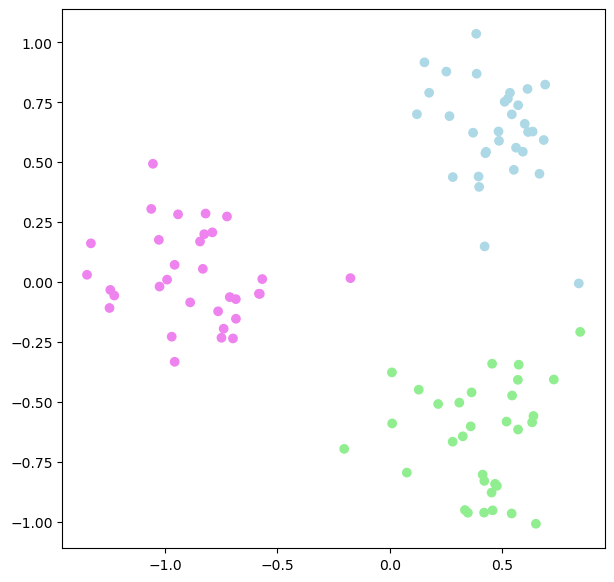

In [105]:
plt.figure(figsize=(7, 7))
plt.scatter(
    # *emb.T,
    *PCA(n_components=2).fit_transform(emb).T,
    c=comm_color,
    # cmap=plt.cm.tab20
)
plt.show()

In [106]:
# Let's take some embeddings from the same communities and compare their dot product
# z1 and z2 are from the same community therefore they should have a bigger dot product than z1 and z3
z1 = emb[np.random.choice(np.where(comm_labels == 0)[0])]
z2 = emb[np.random.choice(np.where(comm_labels == 0)[0])]
z3 = emb[np.random.choice(np.where(comm_labels == 1)[0])]

print(z1.dot(z2))
print(z1.dot(z3))

2.6278327
1.4686928


In [124]:
def rw_embeddings(graph, walks_per_node: int, walk_length: int, dim: int, epochs: int):
    walks = walk_graph(graph, walks_per_node=walks_per_node, walk_length=walk_length)
    for i in range(len(walks)):
        for j in range(walk_length):
            walks[i][j] = str(walks[i][j])

    w2v = Word2Vec(sequences=walks, embedding_dim=dim)
    w2v.train(epochs=epochs)
    emb = np.array([w2v.get_word_vector(str(n)) for n in graph])
    return emb

# SVD / PCA embeddings

$$A = U \cdot S \cdot V^T$$
SVD reminder
- [SVD wiki](https://en.wikipedia.org/wiki/Singular_value_decomposition)
- [SVD youtube tutorial](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=1) -- watch few vids from here

SVD decomposition can be interpreted as an embedding. The space is given by the $U$ matrix, $V^T$ are coordinates in $U$ and $S$ represents some scaling factor. If we are taking a few columns from $U$ then we can approximate the matrix $A$

In [108]:
import scipy
from sklearn.utils.extmath import svd_flip

In [109]:
# A = nx.to_numpy_array(G_karate)
# A = nx.to_numpy_array(G_football)
A = nx.to_numpy_array(G_comm)
# A = nx.to_numpy_array(G_cora)

In [110]:
# U, S, Vt = np.linalg.svd(A, full_matrices=False)
U, S, Vt = scipy.sparse.linalg.svds(A, k=2)
S = S[::-1]
U, Vt = svd_flip(U[:, ::-1], Vt[::-1])

In [111]:
np.all(np.isclose(U @ np.diag(S) @ Vt, A))

np.False_

C:\Users\Andrei\AppData\Local\Temp\ipykernel_18884\1996262174.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*emb.T, c=comm_color, cmap=plt.cm.tab20)


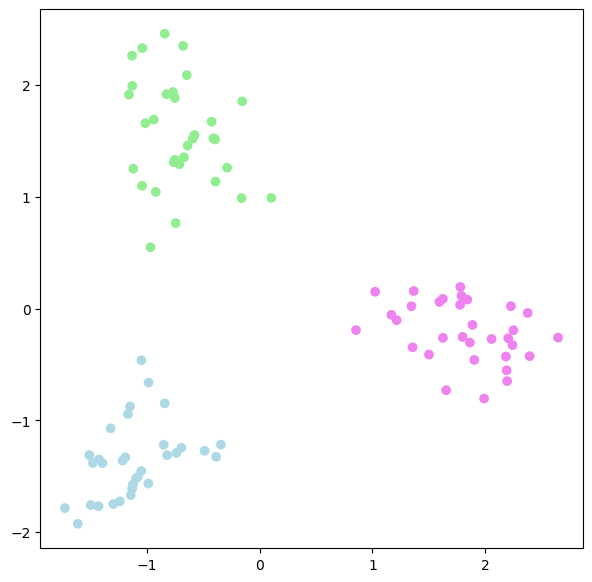

In [112]:
# emb = A @ Vt.T
# emb = np.array(emb.T) # Transform from matrix to array for scatter

# emb = TruncatedSVD(n_components=2).fit_transform(A).T
emb = PCA(n_components=2).fit_transform(A)
plt.figure(figsize=(7, 7))
plt.scatter(*emb.T, c=comm_color, cmap=plt.cm.tab20)

plt.show()

In [113]:
# Let's take some embeddings from the same communities and compare their dot product
# z1 and z2 are from the same community therefore they should have a bigger dot product than z1 and z3
z1 = emb[np.random.choice(np.where(comm_labels == 0)[0])]
z2 = emb[np.random.choice(np.where(comm_labels == 0)[0])]
z3 = emb[np.random.choice(np.where(comm_labels == 1)[0])]

print(z1.dot(z2))
print(z1.dot(z3))

4.282412268595379
-1.8334504373666956


# Spectral embedding

**Laplacian matrix**  
https://en.wikipedia.org/wiki/Laplacian_matrix

$$L = D - A$$
where $A$ is the adjacencty matrix and $D$ is the [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) (a diagonal matrix with the node's degree)

There is a normalized version
$$N = D^{-1/2}LD^{-1/2}$$



In [114]:
print(nx.laplacian_matrix(G_comm).todense())

[[18  0 -1 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [-1  0 24 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 23]]


In [115]:
print(nx.normalized_laplacian_matrix(G_comm).todense())

[[ 1.          0.         -0.04811252 ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [-0.04811252  0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [116]:
def laplacian_embeddings(graph: nx.Graph, dim: int) -> np.array:
    N = nx.normalized_laplacian_matrix(graph)
    _, emb = scipy.sparse.linalg.eigsh(N, k=dim, which="SM", return_eigenvectors=True)
    return emb


dim = 3
emb = laplacian_embeddings(G_comm, dim)

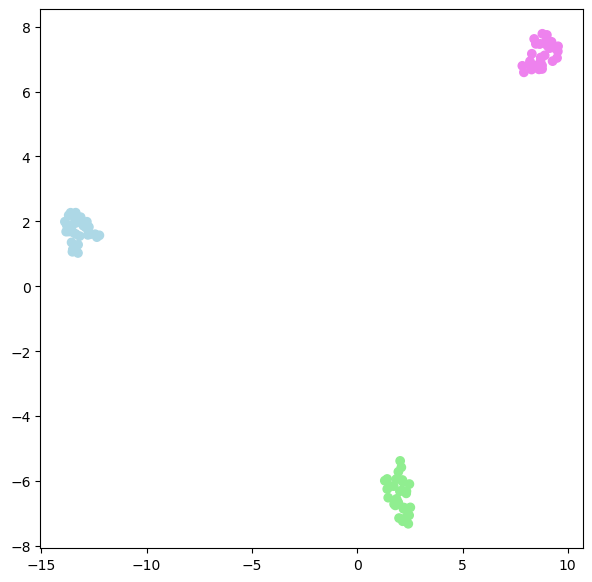

In [117]:
plt.figure(figsize=(7, 7))
plt.scatter(
    # *emb.T,
    *TSNE(n_components=2).fit_transform(emb).T,
    c=comm_color,
    # cmap=plt.cm.tab20
)
plt.show()

In [118]:
dim = 16
emb = laplacian_embeddings(G_cora, dim)

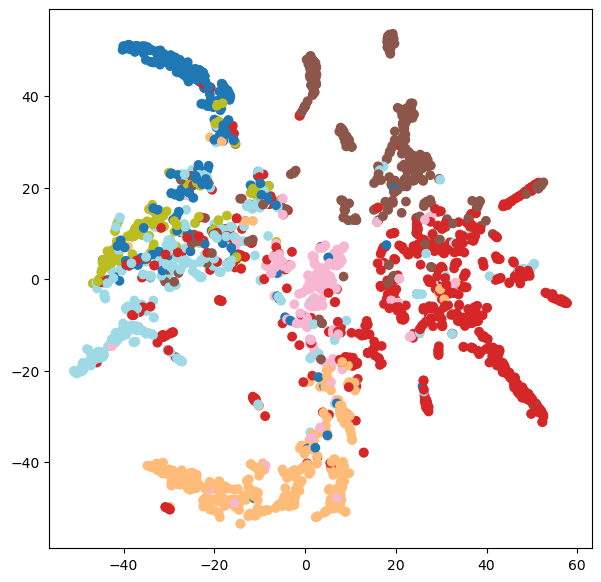

In [119]:
plt.figure(figsize=(7, 7))
plt.scatter(
    # *emb.T,
    *TSNE(n_components=2).fit_transform(emb).T,
    c=cora_color,
    cmap=plt.cm.tab20
)
plt.show()

# Evaluating an embedding

We will train a classifier on the embeddings and evaluate it against the labels

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

In [121]:
def eval_emb(X, y, model, test_sizes):
    scores = []
    for size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
        model.fit(X_train, y_train)
        scores.append(balanced_accuracy_score(model.predict(X_test), y_test))
    return scores

In [125]:
emb1 = rw_embeddings(G_cora, walks_per_node=5, walk_length=5, dim=16, epochs=5)
emb2 = laplacian_embeddings(G_cora, dim=16)

Epoch 1/5, Loss: 0.5323
Epoch 2/5, Loss: 0.3985
Epoch 3/5, Loss: 0.3049
Epoch 4/5, Loss: 0.2147
Epoch 5/5, Loss: 0.1598


In [126]:
emb1.shape

(2485, 16)

In [127]:
y = cora_color
test_sizes = [0.9, 0.8, 0.7, 0.5, 0.2]

algo_scores = []
for emb in tqdm([emb1, emb2]):
    model = GradientBoostingClassifier(random_state=42)
    scores = eval_emb(emb, y, model, test_sizes)
    algo_scores.append(scores)

100%|██████████| 2/2 [00:43<00:00, 21.65s/it]


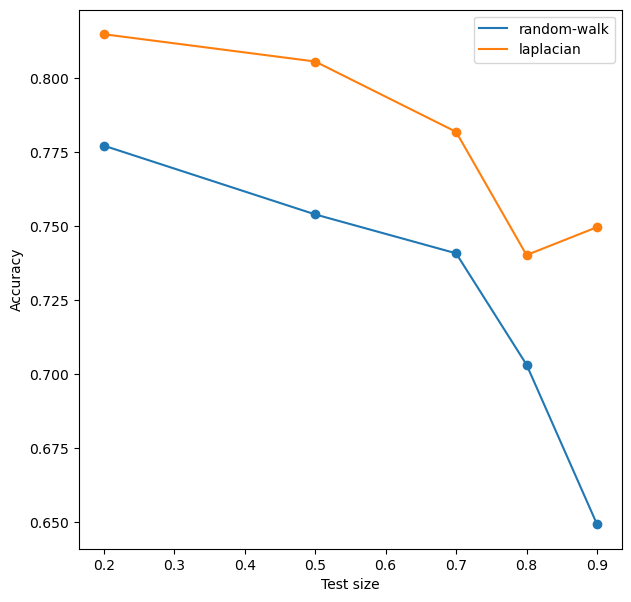

In [128]:
labels = ["random-walk", "laplacian"]
plt.figure(figsize=(7, 7))
for label, scores in zip(labels, algo_scores):
    plt.plot(test_sizes, scores, label=label)
    plt.scatter(test_sizes, scores)

plt.ylabel("Accuracy")
plt.xlabel("Test size")
plt.legend()

# Graph embeddings

1. Average node embeddings
2. Cluster some nodes into super-nodes and run random walks on them
3. [Anonymous walks](https://arxiv.org/pdf/1805.11921.pdf) -- Consider all possible walk **sequences** independend of nodes when running walks. Make a probability distribution over them. That leads to an embedding of the graph. We can learn an embedding for each possible anonymous walk and then learn an embedding for the graph G